In [1]:
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import datasets, model_selection, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir = '/content/drive/MyDrive/PhyC170M_final_project/' # Directory of the project folder in your drive
attributes = pd.read_csv(dir + 'Supercon_attributes.csv').iloc[:,1:]
data = pd.read_csv(dir + 'Supercon_data.csv')
Tc = data.iloc[:,1] # critical temp

In [5]:
# Rescale the data to the range [0,1]. If a column has the same values, change all values to 0
def data_rescale(x, y):
  x_scale = x.copy(deep = True)
  y_scale = y.copy(deep = True)
  # Rescale x
  for i in range(len(x.columns)):
    min = np.min(x.iloc[:,i])
    max = np.max(x.iloc[:,i])
    if min != max:
      x_scale.iloc[:,i] = (x.iloc[:,i] - min) / (max - min)
    else:
      x_scale.iloc[:,i] = x.iloc[:,i] * 0
  # Rescale y
  y_scale = (y_scale - np.min(y)) / (np.max(y) - np.min(y))
  return x_scale, y_scale

#Convert Tc to a log scale and then perform rescaling
attributes_scale, Tc_scale = data_rescale(attributes, Tc)

In [6]:
#Same data split for training the Neural Network 
validate_ratio = 0.1 # Ratio of validation set
test_ratio = 0.15 # Ratio of testing set
random_state = 0 # Use this random state for reproducible results

x_train_all_scale, x_val_scale, y_train_all_scale, y_val_scale = model_selection.train_test_split(attributes_scale, Tc_scale, test_size = validate_ratio, 
                                                                                    random_state = random_state)

x_train_scale, x_test_scale, y_train_scale, y_test_scale = model_selection.train_test_split(x_train_all_scale, y_train_all_scale, test_size = test_ratio,
                                                                    random_state = random_state)

print(x_train_scale.shape)
print(y_train_scale.shape)
print(x_test_scale.shape)
print(y_test_scale.shape)

(12556, 145)
(12556,)
(2216, 145)
(2216,)


In [7]:
# Select those with Tc >= 10K
threshold_scale = (10 - np.min(Tc)) / (np.max(Tc) - np.min(Tc))
x_val_10k_scale = x_val_scale[y_val_scale >= threshold_scale]
y_val_10k_scale = y_val_scale[y_val_scale >= threshold_scale]
x_test_10k_scale = x_test_scale[y_test_scale >= threshold_scale]
y_test_10k_scale = y_test_scale[y_test_scale >= threshold_scale]
x_train_10k_scale = x_train_scale[y_train_scale >= threshold_scale]
y_train_10k_scale = y_train_scale[y_train_scale >= threshold_scale]
print(y_train_10k_scale.shape)


(4786,)


In [11]:
#First try to build model using Data of 10K critical temperature and up
#Edits: Increase the number of layers and decrease the learning rate of the model
#Also increase the number of epochs to fix the leanrning curve
model_10k = Sequential()
model_10k.add(keras.layers.Dense(200, activation='relu', input_shape = (145,)))
model_10k.add(keras.layers.Dense(200, activation='relu'))
model_10k.add(keras.layers.Dense(1, activation= 'linear'))

model_10k.compile(loss='mean_squared_error', metrics=['mean_squared_error'], optimizer = Adam(learning_rate= 0.0001))
history = model_10k.fit(x_train_10k_scale, y_train_10k_scale, epochs=1000,batch_size = 32,
                    validation_data=(x_test_10k_scale, y_test_10k_scale))

#The batch size is a hyperparameter that defines the number of training samples that the neural network uses to update its weights in one iteration
#dataset is divided into batches and each batch is used to update the model's weights once.

#The Adam optimization algorithm is stochastic gradient descent (SGD). It is designed to automatically adapt the learning rate of the neural network during training

Epoch 1/1000
150/150 [==============================] - 1s 4ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 2/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 3/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 4/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 5/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 6/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 7/1000
150

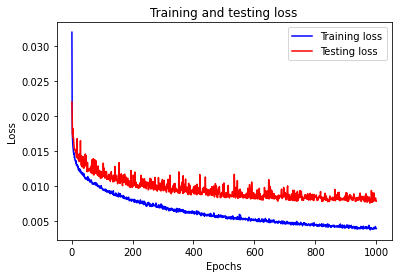

In [12]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Testing loss')

plt.title('Training and testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();
#It looks as if after 1000 epochs the Loss score flattens out, wasting computational power.
#Good agreement between the traning and testing loss, an indication that their is no overfitting or underfitting issues

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

# Recover the unscaled data
y_pred_scale = model_10k.predict(x_val_10k_scale)
y_pred = y_pred_scale * (np.max(Tc) - np.min(Tc)) + np.min(Tc)
y_val = y_val_10k_scale * (np.max(Tc) - np.min(Tc)) + np.min(Tc)

#Mean Squared Error (MSE)
mse = mean_squared_error(y_val, y_pred)
print("MSE:", mse)

#Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

#R^2 score (R^2)
r2 = r2_score(y_val, y_pred)
print("R^2:", r2)


21/21 [==============================] - 1s 11ms/step
MSE: 171.61465164621023
RMSE: 13.100177542545378
R^2: 0.8214761246479638


In [14]:
print(y_pred.shape)
print(np.where(y_pred <= 0))

(643, 1)
(array([128, 207, 626]), array([0, 0, 0]))


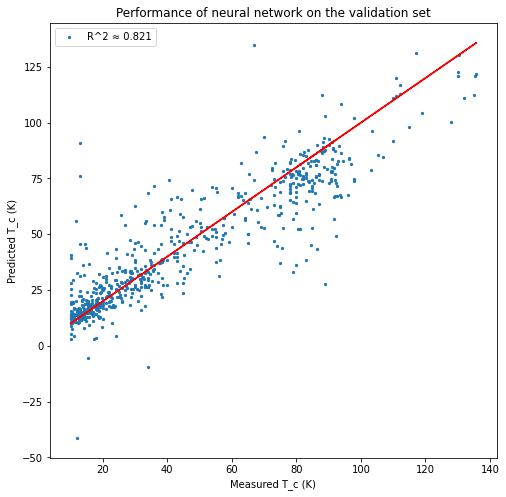

In [15]:
def plot_reg_pred(y_test, y_pred, x_label = 'Measured T_c (K)', y_label = 'Predicted T_c (K)', 
                  title = 'Predicted vs measured critical temperatures'):
  r2 = r2_score(y_test, y_pred)
  plt.figure(figsize = (8,8))
  plt.scatter(y_test, y_pred, s = 5, label = 'R^2 \u2248 %.3f' % (r2))
  plt.plot(y_test, y_test, color = 'red')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.title(title)
  

y_val = y_val_10k_scale * (np.max(Tc) - np.min(Tc)) + np.min(Tc)
plot_reg_pred(y_val, y_pred, title = 'Performance of neural network on the validation set')